# Trabalho Final da Disciplina de Deep Learning 1º/2018

Projeto feito na plataforma **Kaggle** e disponível em [Link](https://www.kaggle.com/tiarles/word2vec-via-gensim-lstm-prediction-via-keras/)

**Este exemplo não acompanha os datasets!**

Segundo Trabalho da disciplina. Profº Rodrigo da Silva Guerra

Objetivo: Implementar uma rede neural (tipo LSTM) utilizando um modelo treinado de palavras com análise por sintaxe (word2vec). 

Link 1: [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

Link 2: [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Parte 1: Word2Vec
A primeira parte do trabalho consiste em treinar um codificador Word2Vec seguindo uma das seguintes propostas:

* Opção 1: Treinar Word2Vec utilizando vocabulário na língua portuguesa, utilizando ferramenta padrão com implementação pronta, tal como gensim.
* Opção 2: Treinar Word2Vec utilizando vocabulário na língua inglesa, mas nesse caso implementando manualmente o algoritmo de treinamento utilizando uma biblioteca tal como TensorFlow.

Em ambos os casos os autores devem demonstrar resultados satisfatórios do treinamento, mostrando como o embedding criado agrupa palavras de categoria semanticamente afim, e mostrando resultados coerentes em operações do tipo rei - homem + mulher = rainha.

Para esta etapa será utilizado a **opção 1** com um dataset de notícias obtido pelo site Kaggle, da Folha de São Paulo. [Link 3](https://www.kaggle.com/marlesson/news-of-the-site-folhauol)

## Parte 2: LSTM
A segunda parte do trabalho consiste em implementar uma LSTM seguindo uma das seguintes propostas:
* Opção 1: Treinar LSTM para classificar sentimentos (ou classe de documento, ou outro tipo de classificação similar). Neste caso a rede deve ser treinada utilizando embeddings que se aproveitam do codificador Word2Vec implementado na Parte 1.
* Opção 2: Treinar LSTM para uma tarefa de predição da próxima palavra. Neste caso se treina a LSTM usando como entrada uma sequência de palavras de um texto, onde a rede neural deve prever a próxima palavra. Também neste caso a rede neural deve ser treinada utilizando os embeddings criados na Parte 1.
* Opção 3: Treinar LSTM para outra tarefa de predição, não necessariamente ligada a processamento de linguagem natural. Essa opção deve ter uma proposta elaborada em detalhe e aprovada pelo professor. Apenas propostas aprovadas serão consideradas para avaliação.

Para esta etapa será utilizado a **opção 1** com um dataset de frases do site *pensador.com* obtido e classicado pelo colega José Augusto Thomas ([Kaggle Profile](https://www.kaggle.com/gutothomas)) no site Kaggle, com frases de felicidade, ódio e tristeza. [Link 4](https://www.kaggle.com/gutothomas/phrases-about-happiness-from-pensadorcom), [Link 5](https://www.kaggle.com/gutothomas/phrases-about-hate-from-pensadorcom) e [Link 6](https://www.kaggle.com/gutothomas/phrases-about-sadness-from-pensadorcom).



## Importações e localização dos datasets
Importação de bibliotecas para manipulação e estruturação de dados e treinamento da rede neural.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from gensim.models.word2vec import Word2Vec
import string
import json
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
import pylab
from sklearn.manifold import TSNE

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/news-of-the-site-folhauol/"))
print(os.listdir("../input/phrases-about-happiness-from-pensadorcom/"))
print(os.listdir("../input/phrases-about-hate-from-pensadorcom/"))
print(os.listdir("../input/phrases-about-sadness-from-pensadorcom/"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['articles.csv']
['frases_sobre_felicidade.json']
['frases_de_odio.json']
['frases-tristes.json']


## Descrição de Funções
Algumas funções para manipulação do texto obtido pelo dataset de notícias.

In [3]:
# # functions

def remove_punctuation(phrase):
    phrase_aux = phrase
    for punc in string.punctuation:
        phrase_aux = phrase_aux.replace(punc, ' ')
    return phrase_aux


def remove_punctuation_and_split_sentence(phrase):
    phrase_aux = phrase
    phrase_aux = remove_punctuation(phrase_aux)
    phrase_aux = remove_punctuation(phrase_aux).split()
    return phrase_aux

## Preparação do dataset de notícias

O dataset é importado e logo após é separados somente o necessário para o treinamento do word2vec, ver mais informações do dataset no [Link 3](https://www.kaggle.com/marlesson/news-of-the-site-folhauol)

In [4]:
articles = pd.read_csv('../input/news-of-the-site-folhauol/articles.csv')

In [5]:
textos = articles['title'].tolist() + articles['text'].tolist()
del articles
np.random.shuffle(textos)

Cada texto do dataset é processado para ser tranformado em uma frase. Após a frase é livre de pontuações e tranformada numa lista de palavras pela função **remove_punctuation_and_split_sentence($\cdot$)** 

In [6]:
sentences = []

for texto in textos:
    texto = str(texto)
    texto_splited = texto.lower().split('.')
    sentences.extend(texto_splited)

sentences_list = []

for sentence in sentences:
    sentences_list.append(remove_punctuation_and_split_sentence(sentence))

## Treino do modelo com as notícias e teste do modelo

Após a formatação correta de todo o dataset este pode ser utilizado pelos métodos da biblioteca gensim para a criação do modelo word2vec. Os métodos *Phrases* e *Phraser* servem para pré-condicionarem os dados do dataset, unindo palavras que se repetem na sentença como "nova" e "iorque", "baleia" e "jubarte", "sao" e "paulo", por exemplo. A classe Word2Vec atribuida a **model** de fato constrói o modelo de word2vec para ser usado posteriormente pela LSTM.

In [7]:
size_word2vec = 100
from gensim.models import Phrases
from gensim.models.phrases import Phraser

phrases = Phrases(sentences_list, min_count=5)
bigram = Phraser(phrases)
model = Word2Vec(bigram[sentences_list], size=size_word2vec, workers=8, compute_loss=True)
# model = Word2Vec(sentences_list, size=size_word2vec, workers=8, compute_loss=True)
training_loss = model.get_latest_training_loss()
print(training_loss)

82550904.0


## Testes do modelo
Abaixo um teste fazendo operações com os vetores do modelo e mais adiante uma análise utilizando TSNE.

In [8]:
print(model.wv.most_similar(positive=['mulher', 'rei'], negative=['homem']))
print('\n\n')
print(model.wv.most_similar('mulher'))

[('rainha', 0.6549540758132935), ('coroação', 0.6386404037475586), ('musa', 0.6313825249671936), ('companheira', 0.6160791516304016), ('sobrinha', 0.6110304594039917), ('esposa', 0.5929905772209167), ('sogra', 0.5847598314285278), ('ex_namorada', 0.5807205438613892), ('princesa', 0.5793114900588989), ('madrinha', 0.5743816494941711)]



[('esposa', 0.8261587619781494), ('companheira', 0.8187598586082458), ('filha', 0.812404215335846), ('mãe', 0.8117091655731201), ('namorada', 0.8005502223968506), ('amiga', 0.7965868711471558), ('patroa', 0.7751302719116211), ('avó', 0.755382776260376), ('irmã', 0.7527683973312378), ('tia', 0.7517334818840027)]


/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### TSNE

O TSNE é uma forma de reduzir a dimensão dos dados para melhor avaliá-los graficamente. Mais informações no [Link 7](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Foi feita a escolha de $num\_points$ palavras aleatoriamente de todo o vocabulário do modelo, redimensionado pelo modelo TSNE e plotado no gráfico abaixo.

In [9]:
num_points = 300

ind = np.array(list(range(len(model.wv.vocab))))
np.random.shuffle(ind)
ind = ind[:num_points]

labels     = [model.wv.index2word[i] for i in ind]
embeddings = [model.wv.get_vector(word) for word in labels]

In [16]:
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(embeddings)

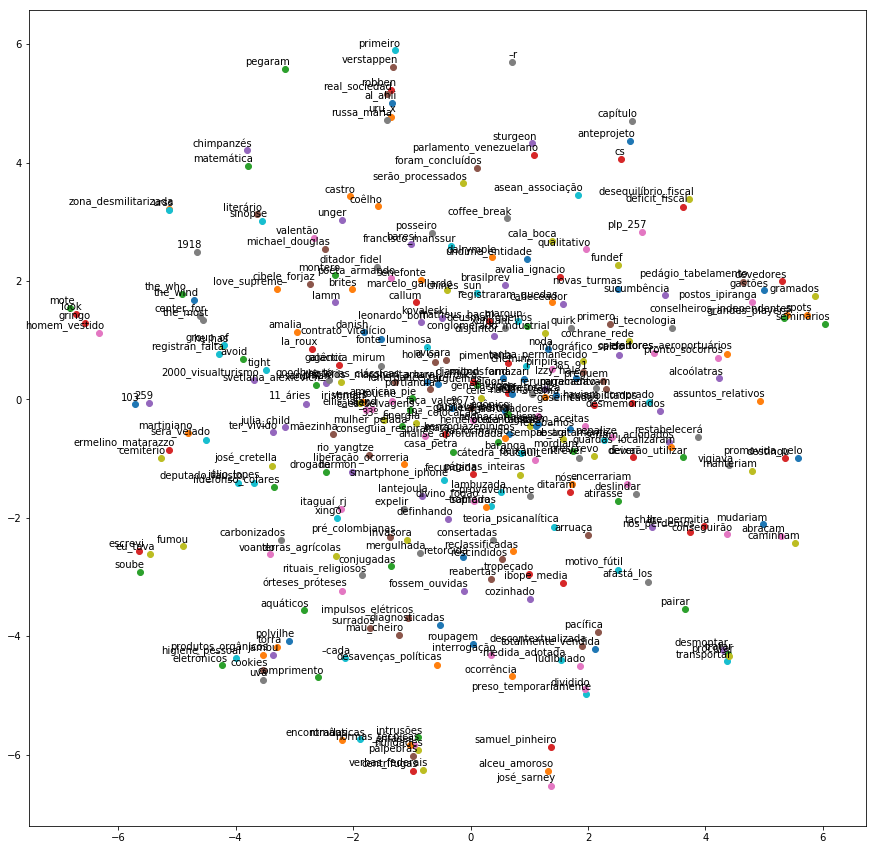

In [17]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()
plot(two_d_embeddings, labels)

## Preparação do dataset de frases

O dataset já estava pré-condicionado e semi-padronizado (case sensitive) utiliza o formato .json.

In [18]:
with open('../input/phrases-about-happiness-from-pensadorcom/frases_sobre_felicidade.json') as f:
    happiness_data = json.load(f)
with open("../input/phrases-about-hate-from-pensadorcom/frases_de_odio.json") as f:
    hate_data = json.load(f)
with open("../input/phrases-about-sadness-from-pensadorcom/frases-tristes.json") as f:
    sadness_data = json.load(f)
    

Concatena-se os três datasets e se atribui uma *label* **target** para cada bloco de dados 

In [19]:
def mergeDataSetAndSetTarget(data1_LSTM, data2_LSTM, data3_LSTM):

    data_LSTM = data1_LSTM + data2_LSTM + data3_LSTM

    target_LSTM = np.zeros((len(data_LSTM), 3))
    
    # Targets:
    # [1,0,0]: frases sobre felicidade
    # [0,1,0]: frases sobre ódio
    # [0,0,1]: frases sobre tristeza
    
    target_LSTM[:len(data1_LSTM)] = np.array([1,0,0])
    target_LSTM[len(data1_LSTM):len(data1_LSTM)+len(data2_LSTM)] = np.array([0,1,0])
    target_LSTM[len(data1_LSTM)+len(data2_LSTM):] = np.array([0,0,1])
    
    return data_LSTM, target_LSTM

data_LSTM, target_LSTM = mergeDataSetAndSetTarget(happiness_data, hate_data, sadness_data)

O treinamento será feito por **Janela deslizante** logo as frases devem ter no mínimo o tamanho da janela $window\_size$ . A rotina abaixo verfica se as frases são maiores ou iguais, senão um valor *unknown* **UNK** é inserido na lista de palavras.

In [20]:
window_size = 5
data_LSTM_pad = []

for data in data_LSTM:
    size = len(data)
    if size < window_size:
        pad_size = window_size - size
        data_LSTM_pad.append(data + ['UNK']*pad_size)
    else:
        data_LSTM_pad.append(data)

data_LSTM = data_LSTM_pad


Criação dos pacotes para treinamento (batches) para o treinamento na LSTM 

In [21]:
data_batches = []
target_batches = []

for data, target in zip(data_LSTM, target_LSTM):
    size = len(data)
    i = 0
    while (i + window_size) <= size:
        data_batches.append(data[i:i+window_size])
        target_batches.append(target)
        i += 1

## Remapeamento dos batches

Transforma as strings dos batches no vetor correspondente no modelo word2vec treinado anteriormente.

In [22]:
sentences_list_w2v = []

sentences_list = data_batches

for sentence in sentences_list:
    sentence_w2v = []
#     print(sentence)
    for word in sentence:
        word = word.lower()
        try:
            sentence_w2v.append(model.wv.get_vector(word))
            #print(model.wv.get_vector(word))
        except KeyError:
            sentence_w2v.append(np.zeros(size_word2vec))
    sentences_list_w2v.append(sentence_w2v)

Atribuição dos dados em batch para as palavras remapeadas pelo modelo **word2vec**

In [23]:
data_batches = sentences_list_w2v

Mistura dos batches  e separação para entre treino e testes

In [24]:
ind = np.array(range(len(data_batches)))

data_batches_ar          = np.array(data_batches)
target_batches_ar        = np.array(target_batches)

In [25]:
np.random.shuffle(ind)

data_batches_sh   = data_batches_ar[ind]
target_batches_sh = target_batches_ar[ind]

In [26]:
size_train = int(len(data_batches_sh) * (9./10.))

x_train = data_batches_sh[:size_train]
y_train = target_batches_sh[:size_train]

x_test = data_batches_sh[size_train:]
y_test = target_batches_sh[size_train:]

## Construção da rede neural
Descrição das camadas da rede neural e da configuração para o treinamento (**.compile($\cdot$)**)

In [78]:
modelRNN = Sequential()
modelRNN.add(LSTM(64, input_shape=(5, 100)))
modelRNN.add(Dense(3))
modelRNN.add(Dropout(0.5))
modelRNN.add(Activation('softmax'))

In [79]:
modelRNN.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['acc'])

## Treinamento

In [80]:
modelRNN.fit(x_train, y_train, epochs=100, batch_size=512, shuffle=False)

Epoch 1/50
135177/135177 [==============================] - 9s 63us/step - loss: 0.1899 - acc: 0.5273
Epoch 2/50
135177/135177 [==============================] - 7s 52us/step - loss: 0.1798 - acc: 0.5556
Epoch 3/50
135177/135177 [==============================] - 7s 53us/step - loss: 0.1763 - acc: 0.5665
Epoch 4/50
135177/135177 [==============================] - 7s 52us/step - loss: 0.1735 - acc: 0.5764
Epoch 5/50
135177/135177 [==============================] - 7s 53us/step - loss: 0.1710 - acc: 0.5863
Epoch 6/50
135177/135177 [==============================] - 7s 53us/step - loss: 0.1683 - acc: 0.5942
Epoch 7/50
135177/135177 [==============================] - 7s 53us/step - loss: 0.1661 - acc: 0.6018
Epoch 8/50
135177/135177 [==============================] - 7s 53us/step - loss: 0.1640 - acc: 0.6091
Epoch 9/50
135177/135177 [==============================] - 7s 53us/step - loss: 0.1612 - acc: 0.6168
Epoch 10/50
135177/135177 [==============================] - 8s 58us/step - loss: 

## Verificação do modelo

Utiliza a parte de testes do dataset para verificar 1) o erro quadrático da rede neural e 2) o quanta a rede acerta

In [81]:
modelRNN.evaluate(x_test, y_test)

15020/15020 [==============================] - 2s 110us/step


[0.1255197035389321, 0.7362183754993342]

## Predições

Utiliza a parte de testes para imprimir a saída da rede e imprime junto o valor alvo 

In [82]:
ind = np.array(range(len(x_test)))
np.random.shuffle(ind)
ind = ind[:50]

predicted = modelRNN.predict(x_test[ind])
target    = y_test[ind]

def max_1_others_0(vetor):
    ret = np.zeros(3)
    ret[np.argmax(vetor)] = 1
    return ret
    
print("%50s | %10s | %s" % ("Rede", "Target", "Acerto?"))
for a, b in zip(predicted, target):
    print("%50s | %10s | %s" % (str(a), str(b), str(np.all(max_1_others_0(a) == b))))

                                              Rede |     Target | Acerto?
                [0.13903558 0.22474347 0.63622093] | [0. 0. 1.] | True
                [0.65677804 0.21781196 0.12541004] | [0. 1. 0.] | False
                [0.92363346 0.04401202 0.0323546 ] | [1. 0. 0.] | True
                [0.99411064 0.00171206 0.00417728] | [1. 0. 0.] | True
       [5.2407786e-04 9.9939346e-01 8.2479957e-05] | [0. 1. 0.] | True
                [0.9659154  0.0230653  0.01101941] | [1. 0. 0.] | True
                [0.02034351 0.01480967 0.96484685] | [0. 1. 0.] | False
                [0.78104156 0.1585019  0.06045655] | [0. 1. 0.] | False
                [0.07768048 0.04620802 0.8761115 ] | [0. 0. 1.] | True
                [0.65967256 0.04182058 0.29850683] | [1. 0. 0.] | True
                [0.74630743 0.16362303 0.09006956] | [1. 0. 0.] | True
                [0.10559417 0.75330704 0.14109877] | [0. 1. 0.] | True
       [3.6057548e-04 3.7979049e-04 9.9925965e-01] | [0. 0. 1.] | True
